* modelを作る前にcross-validationについて考えなければならない
* 筆者はここで以下のように述べている
    - _cross-validation is a step in the process of building a machine learning model which helps us ensure that our models fit the data acuurately and also ensures that we do not overfit._
    - クロスバリデーションとは，機械学習モデルを構築するプロセスにおける1つのステップである．モデルがデータに正確にフィットし，オーバーフィットしないことを保証するのに役立つ．

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import japanize_matplotlib
sns.set(font=["IPAexGothic"])

%matplotlib inline

* dataset
    - winequality-red: https://archive.ics.uci.edu/ml/datasets/wine+quality

In [2]:
df = pd.read_csv("../data/winequality/winequality-red.csv", delimiter=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.shape

(1599, 12)

In [4]:
# qualityは0~10の11種類取りうるが，今回のデータでは，3~8の6種類しか存在しない
df["quality"].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

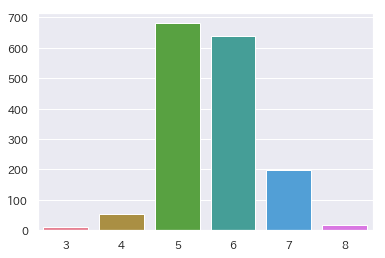

In [5]:
# qualityに偏りがあることがわかる
sns.barplot(
    x=df["quality"].value_counts().index,
    y=df["quality"].value_counts().values,
    palette="husl"
)

* 今回のデータセットでは，6種類のqualityタイプしかないので，それらを0~5の値にマッピングする

In [6]:
quality_mapping = {
    3: 0,
    4: 1,
    5: 2,
    6: 3,
    7: 4,
    8: 5
}

# map関数で辞書の値をマッピングする
df.loc[:, "quality"] = df.quality.map(quality_mapping)

* 分類問題として，今回のデータを捉える
    - その際に，使用するアルゴリズムとしてNeural Networksを思いつくかもしれないが，まずはシンプルなところからスタートするために，決定木を使う


* データセットを2つに分割する（全体: 1599サンプル）
    - 1つは学習用: 1000サンプル
    - もう1つは評価用: 599サンプル

In [7]:
# データフレームをシャッフルしてから，1000サンプル取り出す
df = df.sample(frac=1).reset_index(drop=True)

# 学習用
df_train = df.head(1000)

# 評価/検証用
df_test = df.tail(599)

* 学習データに対して，決定木でモデルを構築する

In [8]:
from sklearn import tree
from sklearn import metrics

# max_depth=3
# 上記以外はデフォルトのパラメータを使用する
clf = tree.DecisionTreeClassifier(max_depth=3)

# 学習に使うカラムを選択する
cols = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol"
]

# targetとして，qualityを使用する
clf.fit(df_train[cols], df_train.quality)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [9]:
# 学習データに対する予測
train_predictions = clf.predict(df_train[cols])

# 評価データに対する予測
test_predictions = clf.predict(df_test[cols])

# 学習データに対する予測のaccuracyを計算する
train_accuracy = metrics.accuracy_score(df_train.quality, train_predictions)

# 評価データに対する予測のaccuracyを計算する
test_accuracy = metrics.accuracy_score(df_test.quality, test_predictions)

In [10]:
print("accuracy for train data:", train_accuracy)
print("accuracy for test data:", test_accuracy)

accuracy for train data: 0.609
accuracy for test data: 0.5642737896494157


* 今回はaccuracyを使ったが，これは最も簡単なメトリクスであるから
* しかしながら，今回の問題においてこれはベストなメトリクスではないかもしれない


* max_depthの値を変化させて，accuracyを確認してみる

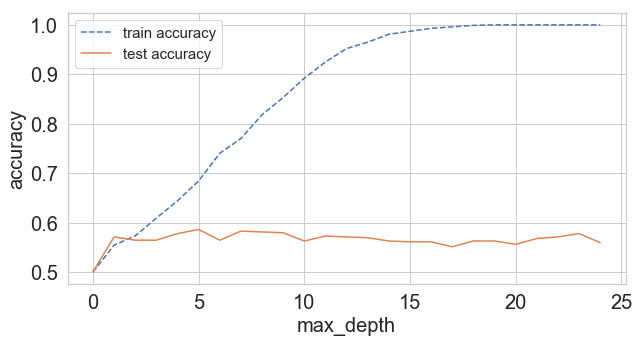

In [11]:
from sklearn import tree
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

%matplotlib inline

# accuracyを保存するリストを作る
# 初期値は0.5
train_accuracies = [0.5]
test_accuracies = [0.5]

for depth in range(1, 25):
    # モデルの初期化
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    
    # 使用する特徴量
    cols = [
        "fixed acidity",
        "volatile acidity",
        "citric acid",
        "residual sugar",
        "chlorides",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "density",
        "pH",
        "sulphates",
        "alcohol"
    ]
    
    # 上記特徴量でのモデルのfit
    clf.fit(df_train[cols], df_train.quality)
    
    # train/testの予測値
    train_predictions = clf.predict(df_train[cols])
    test_predictions = clf.predict(df_test[cols])

    # train/testのaccuracyの計算
    train_accuracy = metrics.accuracy_score(df_train.quality, train_predictions)
    test_accuracy = metrics.accuracy_score(df_test.quality, test_predictions)
    
    # accuracyをリストに追加
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
# 可視化
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plt.plot(train_accuracies, label="train accuracy", ls="--")
plt.plot(test_accuracies, label="test accuracy")
plt.legend(loc="upper left", prop={"size": 15})
plt.xticks(range(0, 26, 5))
plt.xlabel("max_depth", size=20)
plt.ylabel("accuracy", size=20)
plt.show()

* 上記結果を確認すると
    - 学習データに対してはmax_depthが大きい方がaccuracyが良くなっているが、評価データに対してはほとんど変化がない
    - 未知のデータに対する汎化性能が高くないことがわかる
    
    
* 一方でこの結果はoverfittingではない，評価データの精度はほぼ同じであるため
* overfittingの別の定義として
    - _Another definition of overfitting would be when the test loss increases as we keep improving training loss._
    - 学習データのlossを改善し続けると、評価データのlossが増える場合
        - Neural Networksでは一般的に言えること

* 下記図でError(=Loss)とすると，Training / Test(Validation) Loss共にある時点まではが減少していくが，  
    途中でTest Lossは最小値を取り，training lossは減少し続ける
    - Test Lossが最小値を取る時点以降はOverfittingしていくことがわかる
    - この時点で学習を停止する
    

<img src="./figures/fig_overfitting.png" width="500" height="300">

<参考> [Underfitting vs. Overfitting (vs. Best Fitting) in Machine Learning](https://www.analyticsvidhya.com/blog/2020/02/underfitting-overfitting-best-fitting-machine-learning/)

* cross-validation...
* 学習データを2つに分割する
    - 1つはモデルを学習するために使う
    - もう1つはモデルのパフォーマンスを確認するために使う
    - この方法はhold-out setというcross-validationの1種
        - データが大量にある時，モデルによる推論が時間がかかる場合においてこの方法を取ることがある


* 未知のデータに対する汎化性能を持つ良い機械学習モデルを構築するためには，cross-validationを考えることは最も重要なステップである
* 正しいcross-validationの選択方法はデータセットに依存する
* また，cross-validationの方法は複数あり，良く知られているものとして以下がある
    - k-fold cross-validation
    - stratified k-fold cross-validation
    - hold-out based validation
    - leave-one-out cross-validation
    - group k-fold cross-validation
* cross-validationでは，学習用データセットをtrainingとvalidationセットの2つに分割する．
    - 分割の仕方は方法により異なる
    - 分割した内のいくつかでモデルを学習させ，残りのデータで検証する
    - sklearnのCross-validation: evaluating estimator performanceに詳しく載っている（参考）



下記図はk-fold cross-validationの例（k=5）

<img src="./figures/grid_search_cross_validation.png" width="500" height="300">

<参考> [sklearn: Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)

In [12]:
# KFold
# model_selection module of scikit-learn
import pandas as pd
from sklearn import model_selection

# train.csv --> 7セル目の学習データ（1000サンプル）
df = pd.read_csv("../data/winequality/train.csv")
df["kfold"] = -1

# データをランダムにシャッフルする
df = df.sample(frac=1).reset_index(drop=True)

# kfold classの初期化 (k=5)
kf = model_selection.KFold(n_splits=5)

for fold, (trn_, val_) in enumerate(kf.split(X=df)):
    df.loc[val_, 'kfold'] = fold

df.to_csv("../data/winequality/train_kfold.csv", index=False)

In [13]:
df.head(3).append(df.tail(3))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,kfold
0,5.6,0.85,0.05,1.4,0.045,12.0,88.0,0.99240,3.56,0.82,12.9,5,0
1,11.3,0.37,0.41,2.3,0.088,6.0,16.0,0.99880,3.09,0.80,9.3,2,0
2,8.4,0.36,0.32,2.2,0.081,32.0,79.0,0.99640,3.30,0.72,11.0,3,0
997,8.3,0.60,0.25,2.2,0.118,9.0,38.0,0.99616,3.15,0.53,9.8,2,4
998,7.5,0.77,0.20,8.1,0.098,30.0,92.0,0.99892,3.20,0.58,9.2,2,4
999,7.4,0.39,0.48,2.0,0.082,14.0,67.0,0.99720,3.34,0.55,9.2,2,4


* stratified k-fold cross-validation
    - 例えば，偏ったデータセットである2値分類を考える
        - 90%のpositiveサンプルと10%のnegativeサンプルのデータ
        - この場合，先ほどのk-fold cross-validationは使いたくない
            - 理由としては，あるfoldにおいて全てのnegativeサンプルが入ってしまう可能性がある  
                こうなると学習データの中にnegativeサンプルが無い状態が生まれてしまい，精度の悪いモデルができてしまう  
                    （positiveサンプルだけで学習してしまうfoldができてしまう）
    - stratified k-fold cross-validationはそれぞれのfoldで一定割合のラベルを保つように分割する
        - どのfoldでも90%のpositiveサンプルと10%のnegativeサンプルをある程度保った状態ができる

In [14]:
# StratifiedKFold
# model_selection module of scikit-learn
import pandas as pd
from sklearn import model_selection

# train.csv --> 7セル目の学習データ（1000サンプル）
df = pd.read_csv("../data/winequality/train.csv")
df["stratified_kfold"] = -1

# データをランダムにシャッフルする
df = df.sample(frac=1).reset_index(drop=True)

# y = df.target.values
y = df.quality.values

# StratifiedKFold classの初期化 (k=5)
kf = model_selection.StratifiedKFold(n_splits=5)

for fold, (trn_, val_) in enumerate(kf.split(X=df, y=y)):
    df.loc[val_, 'stratified_kfold'] = fold

df.to_csv("../data/winequality/train_stratified_kfold.csv", index=False)

In [15]:
df.head(3).append(df.tail(3))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,stratified_kfold
0,8.3,0.54,0.24,3.4,0.076,16.0,112.0,0.99760,3.27,0.61,9.4,2,0
1,7.4,0.36,0.30,1.8,0.074,17.0,24.0,0.99419,3.24,0.70,11.4,5,0
2,6.1,0.56,0.00,2.2,0.079,6.0,9.0,0.99480,3.59,0.54,11.5,3,0
997,9.1,0.40,0.57,4.6,0.080,6.0,20.0,0.99652,3.28,0.57,12.5,3,4
998,7.4,0.55,0.19,1.8,0.082,15.0,34.0,0.99655,3.49,0.68,10.5,2,4
999,11.4,0.26,0.44,3.6,0.071,6.0,19.0,0.99860,3.12,0.82,9.3,3,4


In [16]:
# TODO: stratified k-fold cross-validationを使った場合のモデルの精度がどうなるか確認する

* データが大量にある場合にはhold-out based validationで問題ない
    - 例えば，100万件のサンプルがある場合，5 fold cross-validationを使うと，
        学習データ: 80万件，検証データ: 20万件のサンプルデータになる  
        選択するアルゴリズムにもよるが，これはかなり計算コストなどがかかる
* Hold-outはTime-seriesデータと相性がいい
    - 例えば，2020年の店の売上を予測する場合，データとして2015-2019年までのデータがある時には  
        2019年をhold-outしておき，2015-2018年のデータを使ってモデルを構築する
* sklearnでは，Time Series Splitという時系列用のcross-validation方法もある

* 回帰問題（regression problems）に対して，stratified k-fold cross-validationを適用する
    - そのままでは適用できないので，分類問題の時のように使うためにtargetをビン分けする
        - ビンの数はサンプル数が（>10k，>100k）では気にする必要がなく，10or20ぐらいで良い
        - 一方でサンプル数が少ない場合には，適切なビンの数を計算するために**Styrge's Rule**を使う

        Styrge's Rule: $$ Number\, of\, Bins = 1 + log_2(N) $$

In [17]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import model_selection

def create_folds(data):
    data["kfold"] = -1
    
    data = data.sample(frac=1).reset_index(drop=True)
    
    # Styrge's Ruleによって，ビンの数を計算する
    num_bins = np.floor(1 + np.log2(len(data))).astype(int)
    
    data.loc[:, "bins"] = pd.cut(data["target"], bins=num_bins, labels=False)
    
    kf = model_selection.StratifiedKFold(n_splits=5)
    
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, "kfold"] = f
        
    # bins columnをdropする
    # data = data.drop("bins", axis=1)
    
    return data


# サンプル数=15000，特徴量の数=100，ターゲット=1
X, y = datasets.make_regression(n_samples=15000, n_features=100, n_targets=1)

df = pd.DataFrame(X, columns=[f"f_{i}" for i in range(X.shape[1])])
df.loc[:, "target"] = y

df = create_folds(df)

In [18]:
df.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_93,f_94,f_95,f_96,f_97,f_98,f_99,target,kfold,bins
0,0.502620,-0.545541,-0.124410,-0.769151,-0.826025,1.299568,0.424840,2.230670,-1.456014,0.870963,...,0.023423,1.583030,-0.636886,-2.036783,-1.724676,-0.578408,0.601278,67.159608,0,8
1,0.039427,-0.829955,0.236517,0.483558,0.746449,-0.324343,1.497730,-0.649552,0.050495,-1.205592,...,-0.159980,0.899229,1.287568,-0.113367,0.445244,-1.526604,-0.237634,18.442098,0,7
2,0.786851,-0.232938,0.691597,-0.597369,2.137211,0.260611,-0.164178,0.913538,-0.502804,-0.944490,...,-1.809029,-2.396885,-0.566652,0.660223,-1.694029,0.790334,1.311604,150.808498,0,9
3,-0.113629,0.201180,-0.292609,-0.021604,-0.292002,0.301919,-0.318012,-0.504263,-2.013959,-0.514203,...,0.166950,0.290302,-0.254789,-0.574107,-1.619215,0.783977,0.749178,-184.507141,0,4
4,-0.336469,1.270158,-0.196471,-0.702282,0.098795,-2.498819,-1.401140,1.715469,1.184004,-0.484865,...,-0.539758,1.788974,0.530610,-0.744473,0.297203,-0.673455,0.471932,132.862388,0,8


* Cross-validationは機械学習モデルを構築する上で第一に最も重要なステップである
* _good cross-validation scheme in which validation data is representative of training and real-world data_
    - good cross-validation schemeを得ることができれば，汎化性能が高い良い機械学習モデルを構築することができる